In [1]:
from get_data_from_GTSRB import gt_preprocessor
from ssd_utils import BBoxUtility
import pickle

NUM_CLASSES = 43
IMAGE_SIZE = (512, 512, 3)

dataset = gt_preprocessor('F:\\GTSDB', NUM_CLASSES)
gt = dataset.data

keys = sorted(gt.keys())
num_train = int(round(0.9 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]

num_val = len(val_keys)

In [2]:
bbox_util = BBoxUtility(NUM_CLASSES + 1, pickle.load(open('prior_boxes_GTSDB_512_mobileNet_ssd.pkl', 'rb')))

In [3]:
from ssd.utils import Generator

gen = Generator(
    gt=gt,
    bbox_util=bbox_util,
    batch_size=8,
    path_prefix='F:\\GTSDB\\',
    train_keys=train_keys,
    val_keys=val_keys,
    image_size=IMAGE_SIZE,
    do_crop=False,
    hflip_prob=0,
    vflip_prob=0,
)

In [4]:
from MobileNet_SSD import build_model

model = build_model(input_shape=IMAGE_SIZE, classes=NUM_CLASSES + 1)

In [5]:
# model.summary()

# model.load_weights('../model/GTSDB/weights.09-0.02.hdf5', by_name=True)

In [6]:
freeze = [
    'input_1', 'conv1', 'conv1_bn', 'conv1_relu',
    'conv_dw_1', 'conv_dw_1_bn', 'conv_dw_1_relu', 'conv_pw_1', 'conv_pw_1_bn', 'conv_pw_1_relu',
    'conv_pad_2', 'conv_dw_2', 'conv_dw_2_bn', 'conv_dw_2_relu', 'conv_pw_2', 'conv_pw_2_bn', 'conv_pw_2_relu',
    'conv_dw_3', 'conv_dw_3_bn', 'conv_dw_3_relu', 'conv_pw_3', 'conv_pw_3_bn', 'conv_pw_3_relu',
    'conv_pad_4', 'conv_dw_4', 'conv_dw_4_bn', 'conv_dw_4_relu', 'conv_pw_4', 'conv_pw_4_bn', 'conv_pw_4_relu',
    'conv_dw_5', 'conv_dw_5_bn', 'conv_dw_5_relu', 'conv_pw_5', 'conv_pw_5_bn', 'conv_pw_5_relu',
    'conv_pad_6', 'conv_dw_6', 'conv_dw_6_bn', 'conv_dw_6_relu', 'conv_pw_6', 'conv_pw_6_bn', 'conv_pw_6_relu',
    'conv_dw_7', 'conv_dw_7_bn', 'conv_dw_7_relu', 'conv_pw_7', 'conv_pw_7_bn', 'conv_pw_7_relu',
    'conv_dw_8', 'conv_dw_8_bn', 'conv_dw_8_relu', 'conv_pw_8', 'conv_pw_8_bn', 'conv_pw_8_relu',
    'conv_dw_9', 'conv_dw_9_bn', 'conv_dw_9_relu', 'conv_pw_9', 'conv_pw_9_bn', 'conv_pw_9_relu',
    # 'conv_dw_10', 'conv_dw_10_bn', 'conv_dw_10_relu', 'conv_pw_10', 'conv_pw_10_bn', 'conv_pw_10_relu',
    # 'conv_dw_11', 'conv_dw_11_bn', 'conv_dw_11_relu', 'conv_pw_11', 'conv_pw_11_bn', 'conv_pw_11_relu',
    # 'conv_pad_12', 'conv_dw_12', 'conv_dw_12_bn', 'conv_dw_12_relu', 'conv_pw_12', 'conv_pw_12_bn', 'conv_pw_12_relu',
    # 'conv_dw_13', 'conv_dw_13_bn', 'conv_dw_13_relu', 'conv_pw_13', 'conv_pw_13_bn', 'conv_pw_13_relu'
]

# for L in model.layers:
#     if L.name in freeze:
#         L.trainable = False

In [5]:
from tensorflow import keras

def schedule(epoch):
    initial_lrate = 3e-3
    drop = 0.9
    return initial_lrate * (drop ** (epoch))

callbacks = [
    keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1,
        save_weights_only=True),
    # keras.callbacks.LearningRateScheduler(lambda epoch, decay=0.9: 3e-3 * (decay ** epoch))
    keras.callbacks.LearningRateScheduler(schedule)
]

In [6]:
from ssd_training import MultiboxLoss

optim = keras.optimizers.Adam()

model.compile(
    optimizer=optim,
    loss=MultiboxLoss(NUM_CLASSES + 1, neg_pos_ratio=2.0).compute_loss
)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
model.fit(
    gen.generate(True),
    steps_per_epoch=100,
    epochs=20,
    verbose=1,
    callbacks=callbacks,
    validation_data=gen.generate(False),
    validation_steps=30,
    # use_multiprocessing=True,
    # workers=1
)

Epoch 1/20


In [48]:
model.load_weights('./checkpoints/weights.07-4.41.hdf5', by_name=True)

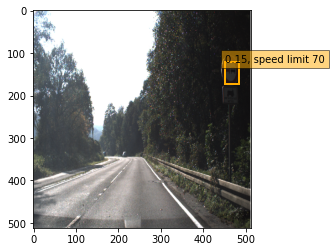

In [54]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('F:\\GTSDB\\00005.ppm', target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

pred = model.predict(img)

result = bbox_util.detection_out(pred)

import matplotlib.pyplot as plt

GTSRB_classes = [
    'speed limit 20',
    'speed limit 30',
    'speed limit 50',
    'speed limit 60',
    'speed limit 70',
    'speed limit 80',
    'restriction ends 80',
    'speed limit 100',
    'speed limit 120',
    'no overtaking',
    'no overtaking',
    'priority at next intersection',
    'priority road',
    'give way',
    'stop',
    'no traffic both ways',
    'no trucks',
    'no entry',
    'danger',
    'bend left',
    'bend right',
    'bend',
    'uneven road',
    'slippery road',
    'road narrows',
    'construction',
    'traffic signal',
    'pedestrian crossing',
    'school crossing',
    'cycles crossing',
    'snow',
    'animals',
    'restriction ends',
    'go right',
    'go left',
    'go straight',
    'go right or straight',
    'go left or straight',
    'keep right',
    'keep left',
    'roundabout',
    'restriction ends',
    'restriction ends',
]

# Parse the outputs.
det_label = result[0][:, 0]
det_conf  = result[0][:, 1]
det_xmin  = result[0][:, 2]
det_ymin  = result[0][:, 3]
det_xmax  = result[0][:, 4]
det_ymax  = result[0][:, 5]

# Get detections with confidence higher than 0.6.
top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.14]

top_conf = det_conf[top_indices]
top_label_indices = det_label[top_indices].tolist()
top_xmin = det_xmin[top_indices]
top_ymin = det_ymin[top_indices]
top_xmax = det_xmax[top_indices]
top_ymax = det_ymax[top_indices]

colors = plt.cm.hsv(np.linspace(0, 1, 43 + 1)).tolist()

# img = img[0,:,:,:]
plt.imshow(img[0,:,:,:] / 255.)
currentAxis = plt.gca()

for i in range(top_conf.shape[0]):
    xmin = int(round(top_xmin[i] * IMAGE_SIZE[1]))
    ymin = int(round(top_ymin[i] * IMAGE_SIZE[0]))
    xmax = int(round(top_xmax[i] * IMAGE_SIZE[1]))
    ymax = int(round(top_ymax[i] * IMAGE_SIZE[0]))
    score = top_conf[i]
    label = int(top_label_indices[i])
    label_name = GTSRB_classes[label - 1]
    display_txt = '{:0.2f}, {}'.format(score, label_name)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

plt.show()

In [5]:
from tensorflow.keras.preprocessing import image
import numpy as np

img = image.load_img('F:\\GTSDB\\00002.ppm', target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

pred = model.predict(img)

result = bbox_util.detection_out(pred)

import matplotlib.pyplot as plt

GTSRB_classes = [
    'speed limit 20',
    'speed limit 30',
    'speed limit 50',
    'speed limit 60',
    'speed limit 70',
    'speed limit 80',
    'restriction ends 80',
    'speed limit 100',
    'speed limit 120',
    'no overtaking',
    'no overtaking',
    'priority at next intersection',
    'priority road',
    'give way',
    'stop',
    'no traffic both ways',
    'no trucks',
    'no entry',
    'danger',
    'bend left',
    'bend right',
    'bend',
    'uneven road',
    'slippery road',
    'road narrows',
    'construction',
    'traffic signal',
    'pedestrian crossing',
    'school crossing',
    'cycles crossing',
    'snow',
    'animals',
    'restriction ends',
    'go right',
    'go left',
    'go straight',
    'go right or straight',
    'go left or straight',
    'keep right',
    'keep left',
    'roundabout',
    'restriction ends',
    'restriction ends',
]


img = image.load_img('F:\\GTSDB\\00204.ppm', target_size=(300, 300))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

plt.imshow(img[0,:,:,:] / 255.)
currentAxis = plt.gca()

colors = plt.cm.hsv(np.linspace(0, 1, 44)).tolist()

for i in dataset.data['00204.ppm']:
    xmin = int(round(i[0] * img.shape[2]))
    ymin = int(round(i[1] * img.shape[1]))
    xmax = int(round(i[2] * img.shape[2]))
    ymax = int(round(i[3] * img.shape[1]))
    score = 1
    label = int(i[0])
    label_name = GTSRB_classes[label - 1]
    display_txt = '{:0.2f}, {}'.format(score, label_name)
    coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
    color = colors[label]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
    currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

plt.show()


ValueError: in user code:

    d:\python_3.6.7\lib\site-packages\tensorflow\python\keras\engine\training.py:1513 predict_function  *
        return step_function(self, iterator)
    E:\MobileNet\ssd\ssd_layer.py:170 call  *
        prior_boxes_tensor = K.expand_dims(K.variable(prior_boxes), 0)
    d:\python_3.6.7\lib\site-packages\tensorflow\python\keras\backend.py:1092 variable  **
        constraint=constraint)
    d:\python_3.6.7\lib\site-packages\tensorflow\python\ops\variables.py:262 __call__
        return cls._variable_v2_call(*args, **kwargs)
    d:\python_3.6.7\lib\site-packages\tensorflow\python\ops\variables.py:256 _variable_v2_call
        shape=shape)
    d:\python_3.6.7\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    d:\python_3.6.7\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3339 creator
        return next_creator(**kwargs)
    d:\python_3.6.7\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    d:\python_3.6.7\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3339 creator
        return next_creator(**kwargs)
    d:\python_3.6.7\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    d:\python_3.6.7\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3339 creator
        return next_creator(**kwargs)
    d:\python_3.6.7\lib\site-packages\tensorflow\python\ops\variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    d:\python_3.6.7\lib\site-packages\tensorflow\python\eager\def_function.py:700 invalid_creator_scope
        "tf.function-decorated function tried to create "

    ValueError: tf.function-decorated function tried to create variables on non-first call.
